# EDA

- Author: Joseph
- Date: 2022-09-14

In [1]:
import os
import subprocess
import operator
from pathlib import Path
from datetime import datetime

from tqdm import tqdm
import pandas as pd
from pandas.tseries.frequencies import to_offset
import matplotlib.pyplot as plt
import seaborn as sns

The dataset is from
https://www.kaggle.com/tencars/392-crypto-currency-pairs-at-minute-resolution.


Firstly, let's count the number of files:

In [14]:
csv_files = os.listdir("data")
print(f"There are {len(csv_files)} csv files.")

There are 465 csv files.


Then, we want to know the begin time and end time,
i.e., the historical period, of the each pair/cryptocurrency.
We create a variable `data_timerange` to store
this information:

In [17]:
data_timerange = {
    "pair_name": [],
    "base": [],
    "quote": [],
    "start_time": [],
    "end_time": []
}
for csv_file in tqdm(csv_files):
    pair_name = csv_file.replace(".csv", "")
    if "-" in pair_name:
        base_coin, quote_coin = pair_name.split("-")
    else:
        base_coin = pair_name[:-3]
        quote_coin = pair_name[-3:]

    # # Use linux command `awk` to fast analyze the data
    # cmd = "awk -F ',' 'NR==2 {print $1} END {print $1}' data/" + csv_file
    # p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
    # dt = p.stdout.read()[:-1].decode("utf-8")
    # if dt.count("\n") != 1:
    #     continue
    # start_str, end_str = dt.split("\n")
    # start_dt = datetime.fromtimestamp(int(start_str)/1000)
    # end_dt = datetime.fromtimestamp(int(end_str)/1000)

    # Use pandas to analyze the data (less efficient)
    # df = pd.read_csv(f"data/{csv_file}")
    # if df.empty:
    #     continue
    # start_dt = datetime.fromtimestamp(int(df.iloc[0]["time"]/1000))
    # end_dt = datetime.fromtimestamp(int(df.iloc[-1]["time"]/1000))

    # os independent method to analyze the data
    with open(f"data/{csv_file}", "r") as f:
        start_str = None
        end_str = None
        for i, row in enumerate(f):
            if i == 1:
                start_str = row.split(",")[0]
            else:
                pass
        if i > 0:
            end_str = row.split(",")[0]
        if start_str is None or end_str is None:
            continue
        start_dt = datetime.fromtimestamp(int(start_str)/1000)
        end_dt = datetime.fromtimestamp(int(end_str)/1000)

    data_timerange["pair_name"].append(pair_name)
    data_timerange["base"].append(base_coin)
    data_timerange["quote"].append(quote_coin)
    data_timerange["start_time"].append(start_dt)
    data_timerange["end_time"].append(end_dt)
data_timerange = pd.DataFrame(data_timerange)

100%|██████████| 465/465 [00:35<00:00, 13.00it/s]


We can peek at the result, and save it.

In [18]:
data_timerange.to_csv("EDA_results/data_timerange.csv")
data_timerange.head()

,pair_name,base,quote,start_time,end_time
0,1inch-usd,1inch,usd,2021-08-11 03:27:00,2021-08-29 21:14:00
1,1inch-ust,1inch,ust,2021-08-11 03:18:00,2021-08-29 21:16:00
2,aaabbb,aaa,bbb,2020-06-24 17:43:00,2022-09-29 17:49:00
3,aave-usd,aave,usd,2021-08-11 03:21:00,2021-08-29 21:15:00
4,aave-ust,aave,ust,2021-08-11 03:20:00,2021-08-29 21:11:00


To develop a meaningful trading strategy, sufficient
historical data must be available.
Since many of the cryptocurrencies either emerge late
or fail to survive, they are not qualified as the
trading instruments. Here we are only interested in
those that have a complete history from 2020-01-01 to 2022-08-10.

We are going to use 2 years' historical data (
2020-01-01 - 2021-12-31) as the training dataset to develop our
strategy; while leaving the 8 months' data (2022-01-01 -
2022-08-10) as the testing dataset. We will develop a
strategy denominated on`USD`, therefore we
only consider`USD`as the quote currency.

We can find out the number of cryptocurrency that satisfies
these criteria is 73:

In [19]:
data_timerange_selected = data_timerange[
    (data_timerange.start_time <= "2020-01-01")
    & (data_timerange.end_time >= "2022-08-10")
    & (data_timerange.quote == "usd")
].reset_index(inplace=False)
print(f"Number of pairs that are qualified: {data_timerange_selected.shape[0]}")

Number of pairs that are qualified: 76


Among the 73 pairs of cryptocurrencies, they are not being
traded equally actively. We should expect some of them
are highly liquid, while some of them are traded less
frequently. A security that is traded less frequently
means there might not be sufficient historical data for
us to develop a meaningful strategy (as there could
be many`NAN`values, i.e., missing values, in the dataset).

Hence we need to find out those with high liquidity.
To this end, let's measure the average number of records
within these selected 73 pairs:


In [30]:
start_dt = datetime(2020, 1, 1)
end_dt = datetime(2022, 1, 1)
num_days = (end_dt - start_dt).days
start_ts = start_dt.timestamp() * 1000
end_ts = end_dt.timestamp() * 1000
data_timerange_selected_count = {}
for i, row in tqdm(data_timerange_selected.iterrows()):

    # # Linux awk command to count the data
    # cmd = (
    #     f"awk '$1 >= {start_ts} && $1 <= {end_ts} "
    #     "{ count++ } END { print count }' "
    #     f"data/{row.pair_name}.csv"
    # )
    # p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
    # res = p.stdout.read()[:-1].decode("utf-8")

    # os independent method to count the data
    with open(f"data/{row.pair_name}.csv", "r") as f:
        res = 0
        for i, line in enumerate(f):
            if i == 0:
                continue
            dt = float(line.split(",")[0])
            if dt < start_ts:
                continue
            elif dt > end_ts:
                break
            else:
                res += 1

    # Average number of 1min bar in 1 hour
    avg_num_bars = float(res) / num_days / 24.0
    data_timerange_selected_count[row.pair_name] = avg_num_bars

sorted_data_timerange_selected_count = dict(
    sorted(data_timerange_selected_count.items(),
           key=operator.itemgetter(1),
           reverse=True)
)
sorted_data_timerange_selected_count

76it [00:34,  2.19it/s]


{'btcusd': 59.25518695850433,
 'ethusd': 56.3641130870953,
 'xrpusd': 53.969619243046054,
 'leousd': 48.91461468308253,
 'ustusd': 47.54896260829913,
 'ltcusd': 46.14073187414501,
 'eosusd': 37.613486092111266,
 'trxusd': 27.813212494300046,
 'dshusd': 27.516301869585046,
 'omgusd': 27.451208390332877,
 'iotusd': 27.155095759233927,
 'neousd': 27.078317373461015,
 'xtzusd': 26.42208162334701,
 'gtxusd': 26.08635430916553,
 'zecusd': 25.733983128134977,
 'etcusd': 24.311958504331965,
 'bsvusd': 24.005984952120382,
 'xmrusd': 22.0483926128591,
 'xlmusd': 21.82871637026904,
 'algusd': 19.270234838121294,
 'vsyusd': 18.53049475604195,
 'zrxusd': 17.59980620155039,
 'uosusd': 16.973210214318286,
 'atousd': 14.967852257181944,
 'ampusd': 14.233983128134975,
 'clousd': 13.399167806657546,
 'datusd': 9.714261285909712,
 'daiusd': 9.527416780665755,
 'bttusd': 9.041666666666666,
 'iqxusd': 8.87220702234382,
 'etpusd': 8.236662106703147,
 'vetusd': 7.376823985408117,
 'gntusd': 6.760886912904696

We can see that `BTC` and `ETH` are trading most actively; while
coins such as`BNT`and `LYM` are almost inactive. The table shows
that there are 59 bars (1-min OHLCV) in every hour for `BTC`, and 57
bars for `ETH`, which indicates high liquidity for these two
cryptocurrencies. The less this number becomes, the more illiquid
it becomes.

If we require that there are at least 30 1-min bars in an hour (
it means the portion of missing values should not exceed 50%),
eight pairs are qualified for this liquidity criteria:

In [39]:
liquid_pairs = [
    k for k, v in sorted_data_timerange_selected_count.items()
    if v > 27.4
]
liquid_pairs

['btcusd',
 'ethusd',
 'xrpusd',
 'leousd',
 'ustusd',
 'ltcusd',
 'eosusd',
 'trxusd',
 'dshusd',
 'omgusd']

We can look at the price movements of these eight pairs:

10it [00:21,  2.17s/it]


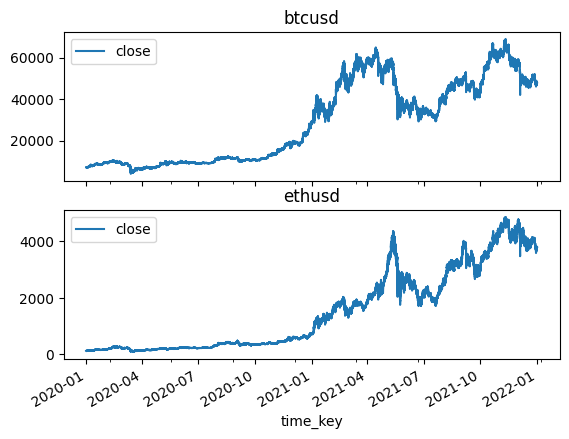

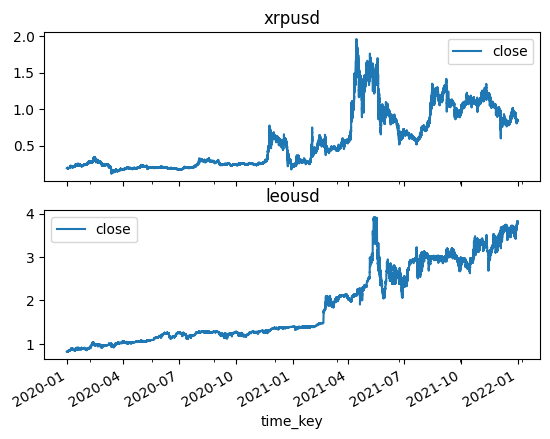

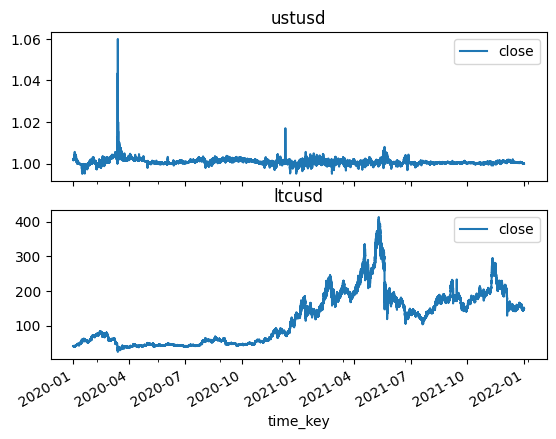

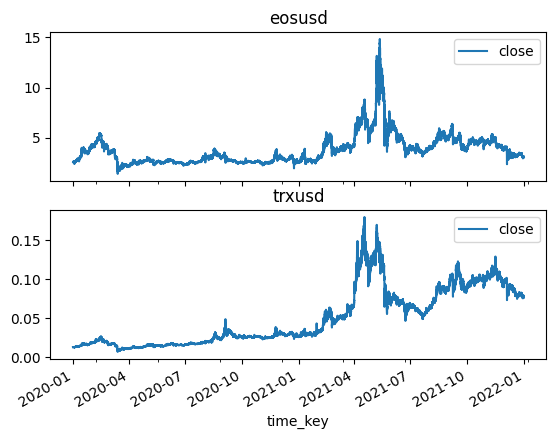

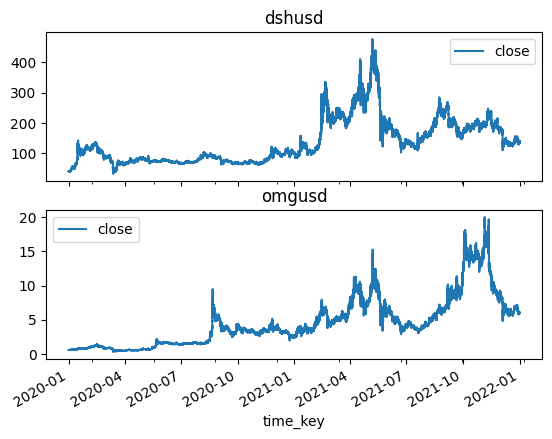

In [40]:
for i, pair_name in tqdm(enumerate(liquid_pairs)):
    if i % 2 == 0:
        fig, axes = plt.subplots(
            nrows=2, #data_universe.shape[0],
            ncols=1,
            sharex=True
        )
    df = pd.read_csv(f"data/{pair_name}.csv")
    df = df[
        (df.time >= start_ts)
        & (df.time <= end_ts)
    ]
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df[["time_key", "close"]].set_index("time_key").plot(
        ax=axes[i%2],
        title=pair_name)

We can see that `BTC`, `ETH`, `XRP`, `LTC`,`EOS`and`TRX` show
some sort of similarity in price movement, but `LEO` and
`UST` differ from the others. This is understandable as
`UST`is pegged to`USD`, and`LEO`is the utility token intended
for the use on the Bitfinex exchange and other trading platforms
managed by its parent company iFinex.

We can see it more clear in a correlation table and correlation
heatmap:

In [41]:
corr_df = None
for i, pair_name in tqdm(enumerate(liquid_pairs)):
    df = pd.read_csv(f"data/{pair_name}.csv")
    df = df[
        (df.time >= start_ts)
        & (df.time <= end_ts)
    ]
    df = df[["time", "close"]].set_index("time")
    df.columns = [pair_name]
    if corr_df is None:
        corr_df = df
    else:
        corr_df = corr_df.join(df, how="outer")

corr_df = corr_df.ffill().bfill()

10it [00:09,  1.04it/s]


In [42]:
corr_df.corr()

,btcusd,ethusd,xrpusd,leousd,ustusd,ltcusd,eosusd,trxusd,dshusd,omgusd
btcusd,1.000000,0.903708,0.842254,0.837520,-0.296324,0.935835,0.640746,0.895984,0.847763,0.842623
ethusd,0.903708,1.000000,0.888743,0.960288,-0.234449,0.836304,0.614797,0.906544,0.732719,0.856594
xrpusd,0.842254,0.888743,1.000000,0.847859,-0.246387,0.875670,0.805218,0.964608,0.854682,0.830168
leousd,0.837520,0.960288,0.847859,1.000000,-0.227896,0.760597,0.568446,0.864746,0.669171,0.772955
ustusd,-0.296324,-0.234449,-0.246387,-0.227896,1.000000,-0.277481,-0.221827,-0.247396,-0.275018,-0.226967
ltcusd,0.935835,0.836304,0.875670,0.760597,-0.277481,1.000000,0.824901,0.908005,0.945917,0.780272
eosusd,0.640746,0.614797,0.805218,0.568446,-0.221827,0.824901,1.000000,0.793590,0.895466,0.605767
trxusd,0.895984,0.906544,0.964608,0.864746,-0.247396,0.908005,0.793590,1.000000,0.874532,0.861379
dshusd,0.847763,0.732719,0.854682,0.669171,-0.275018,0.945917,0.895466,0.874532,1.000000,0.707459
omgusd,0.842623,0.856594,0.830168,0.772955,-0.226967,0.780272,0.605767,0.861379,0.707459,1.000000


<AxesSubplot: >

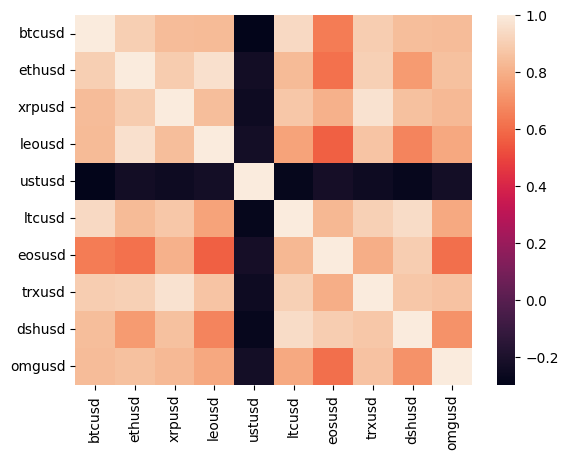

In [43]:
sns.heatmap(corr_df.corr())

As expected,`UST` and `LEO` do not correlate significantly
with other cryptocurrencies. `EOS` also in general shows less
correlation with other cryptocurrencies, although it shows
noticable positive correlaiton with `LTC`.

Therefore we have found out six pairs of cryptocurrencies that
are in general liquid and correlated:

In [44]:

liquid_correlated_pairs = liquid_pairs[:]
liquid_correlated_pairs.remove('ustusd')
liquid_correlated_pairs.remove('leousd')
liquid_correlated_pairs

['btcusd',
 'ethusd',
 'xrpusd',
 'ltcusd',
 'eosusd',
 'trxusd',
 'dshusd',
 'omgusd']

We want to see the active trading hours of these six pairs.

8it [00:24,  3.07s/it]


,max,min,mean,median,std
btcusd,59.501366,58.721311,59.174237,59.273907,0.246543
ethusd,57.646175,54.815574,56.287113,56.394809,0.841036
xrpusd,56.127049,51.045082,53.895890,54.597678,1.659752
ltcusd,49.780055,43.010929,46.077698,45.955601,1.928941
eosusd,42.528689,33.484973,37.562102,37.598361,2.453172
trxusd,30.606557,25.881148,27.775216,27.657104,1.234913
omgusd,31.530055,25.012295,27.413707,26.997268,1.764329
dshusd,32.142077,24.639344,27.478711,27.298497,1.962010


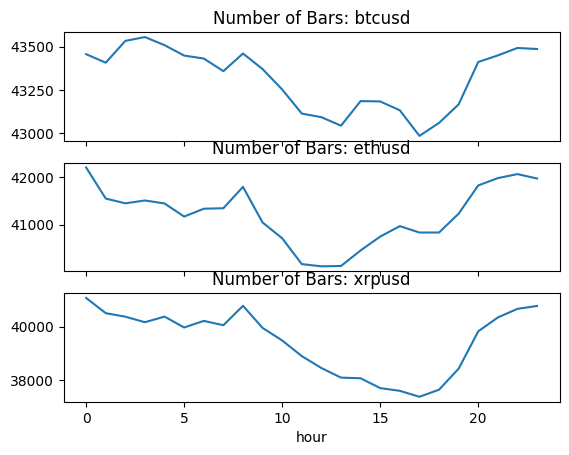

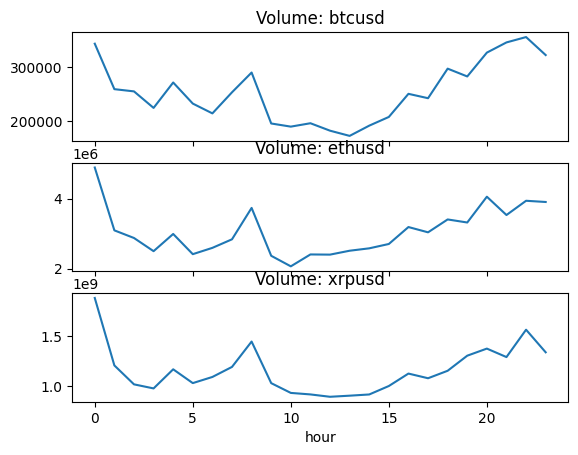

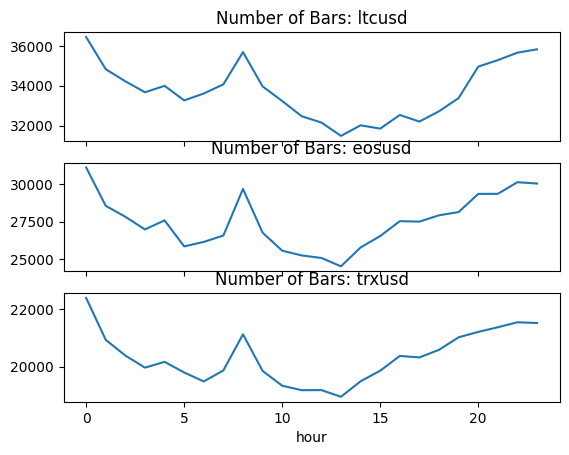

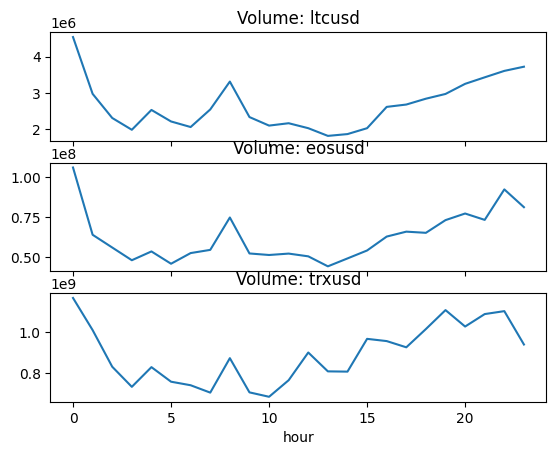

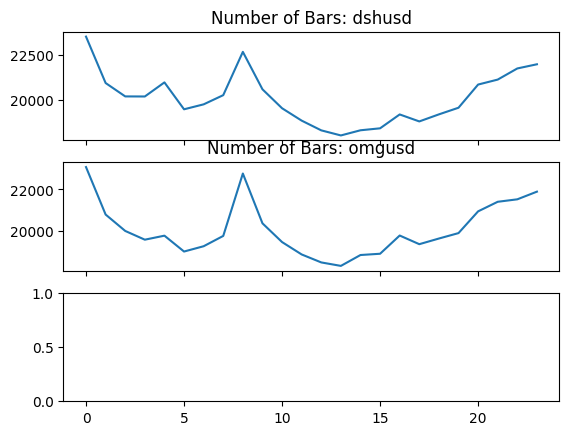

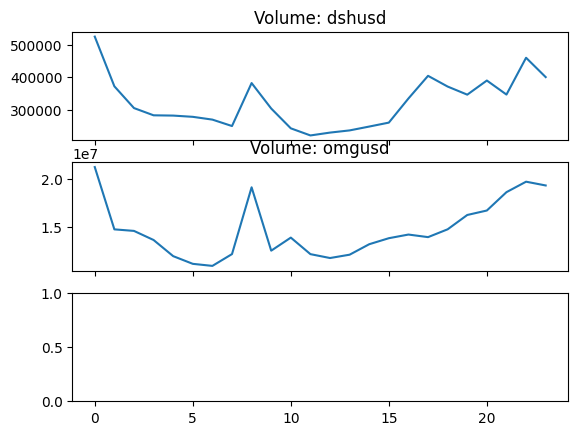

In [45]:
num_bars_in_1hr = {}
for i, pair in tqdm(enumerate(liquid_correlated_pairs)):
    if i % 3 == 0:
        fig1, axes1 = plt.subplots(
            nrows=3,
            ncols=1,
            sharex=True
        )
        fig2, axes2 = plt.subplots(
            nrows=3,
            ncols=1,
            sharex=True
        )
    df = pd.read_csv(f"data/{pair}.csv")
    df = df[
        (df.time >= start_ts)
        & (df.time <= end_ts)
    ]
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df["date"] = df.time_key.apply(lambda x: x.date())
    df["hour"] = df.time_key.apply(lambda x: x.hour)
    num_days = len(df.date.unique())
    # Average number of bars in that particular hour
    df1 = df.groupby("hour").agg({
        "time": "count",
        "volume": "sum"}
    )
    df1["time"].plot(ax=axes1[i%3], title=f"Number of Bars: {pair}")
    df1["volume"].plot(ax=axes2[i%3], title=f"Volume: {pair}")
    num_bars_in_1hr[pair] = {
        "max": df1["time"].max() / num_days,
        "min": df1["time"].min() / num_days,
        "mean": df1["time"].mean() / num_days,
        "median": df1["time"].median() / num_days,
        "std": df1["time"].std() / num_days
    }
num_bars_in_1hr = pd.DataFrame(num_bars_in_1hr).T
num_bars_in_1hr = num_bars_in_1hr.sort_values(by="min", ascending=False)
num_bars_in_1hr

As we can see, from the perspective of either the number of
bars per hour or the total trading volume per hour, all six pairs
have similar active trading hours. In general the market is
relatively active at around 9 am (a small peak) and from 4 pm to 2 am.
The inactive period for `XRP` is a bit longer than the
other cryptocurrencies. This may indicate that the dominant investors
of different cryptocurrencies are likely the same group of people,
or at least from the same time zones.

We can prepare the backtesting data at different intervals: 1 min
(original), 5 min, 15 min, 30 min, and 60 min. Later we can develop the strategy
and test it on different datasets.

In [46]:
for i, pair_name in tqdm(enumerate(liquid_correlated_pairs)):
    save_pair_name = (pair_name[:-3] + "." + pair_name[-3:]).upper()
    df = pd.read_csv(f"data/{pair_name}.csv")
    df = df[
        (df.time >= start_ts)
        & (df.time <= end_ts)
    ]
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df["date"] = df.time_key.apply(lambda x: x.date())
    for date_ in df.date.unique():
        df_daily = df[df.date == date_][
            ["time_key", "open", "high", "low", "close", "volume"]
        ].set_index("time_key")

        date_str = date_.strftime("%Y-%m-%d")
        Path(f"clean_data/k_line/K_1M/{save_pair_name}").mkdir(parents=True, exist_ok=True)
        df_daily.to_csv(f"clean_data/k_line/K_1M/{save_pair_name}/{date_str}.csv",
                        index=True)

        # resample to 5min, 15min
        df_daily_resampled = {}
        for period in ("5min", "15min", "30min", "60min"):
            df_daily_resampled[period] = pd.DataFrame(
                index=df_daily.index,
                columns=["open", "high", "low", "close", "volume"]
            )
            df_daily_resampled[period]['open'] = df_daily.open.resample(period).first()
            df_daily_resampled[period]['high'] = df_daily.high.resample(period).max()
            df_daily_resampled[period]['low'] = df_daily.low.resample(period).min()
            df_daily_resampled[period]['close'] = df_daily.close.resample(period).last()
            df_daily_resampled[period]['volume'] = df_daily.volume.resample(period).sum()
            df_daily_resampled[period].index = df_daily.index + to_offset(period)
            df_daily_resampled[period] = df_daily_resampled[period].dropna()

            kline_str = "K_" + period.replace("min", "") + "M"
            if kline_str == "K_60M":
                kline_str = "K_1H"
            Path(f"clean_data/k_line/{kline_str}/{save_pair_name}").mkdir(
                parents=True, exist_ok=True
            )
            df_daily_resampled[period].to_csv(
                f"clean_data/k_line/{kline_str}/{save_pair_name}/{date_str}.csv",
                index=True
            )


8it [06:55, 51.88s/it]
